/root/.local/share/virtualenvs/sam-ocr-AR7SBuFn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


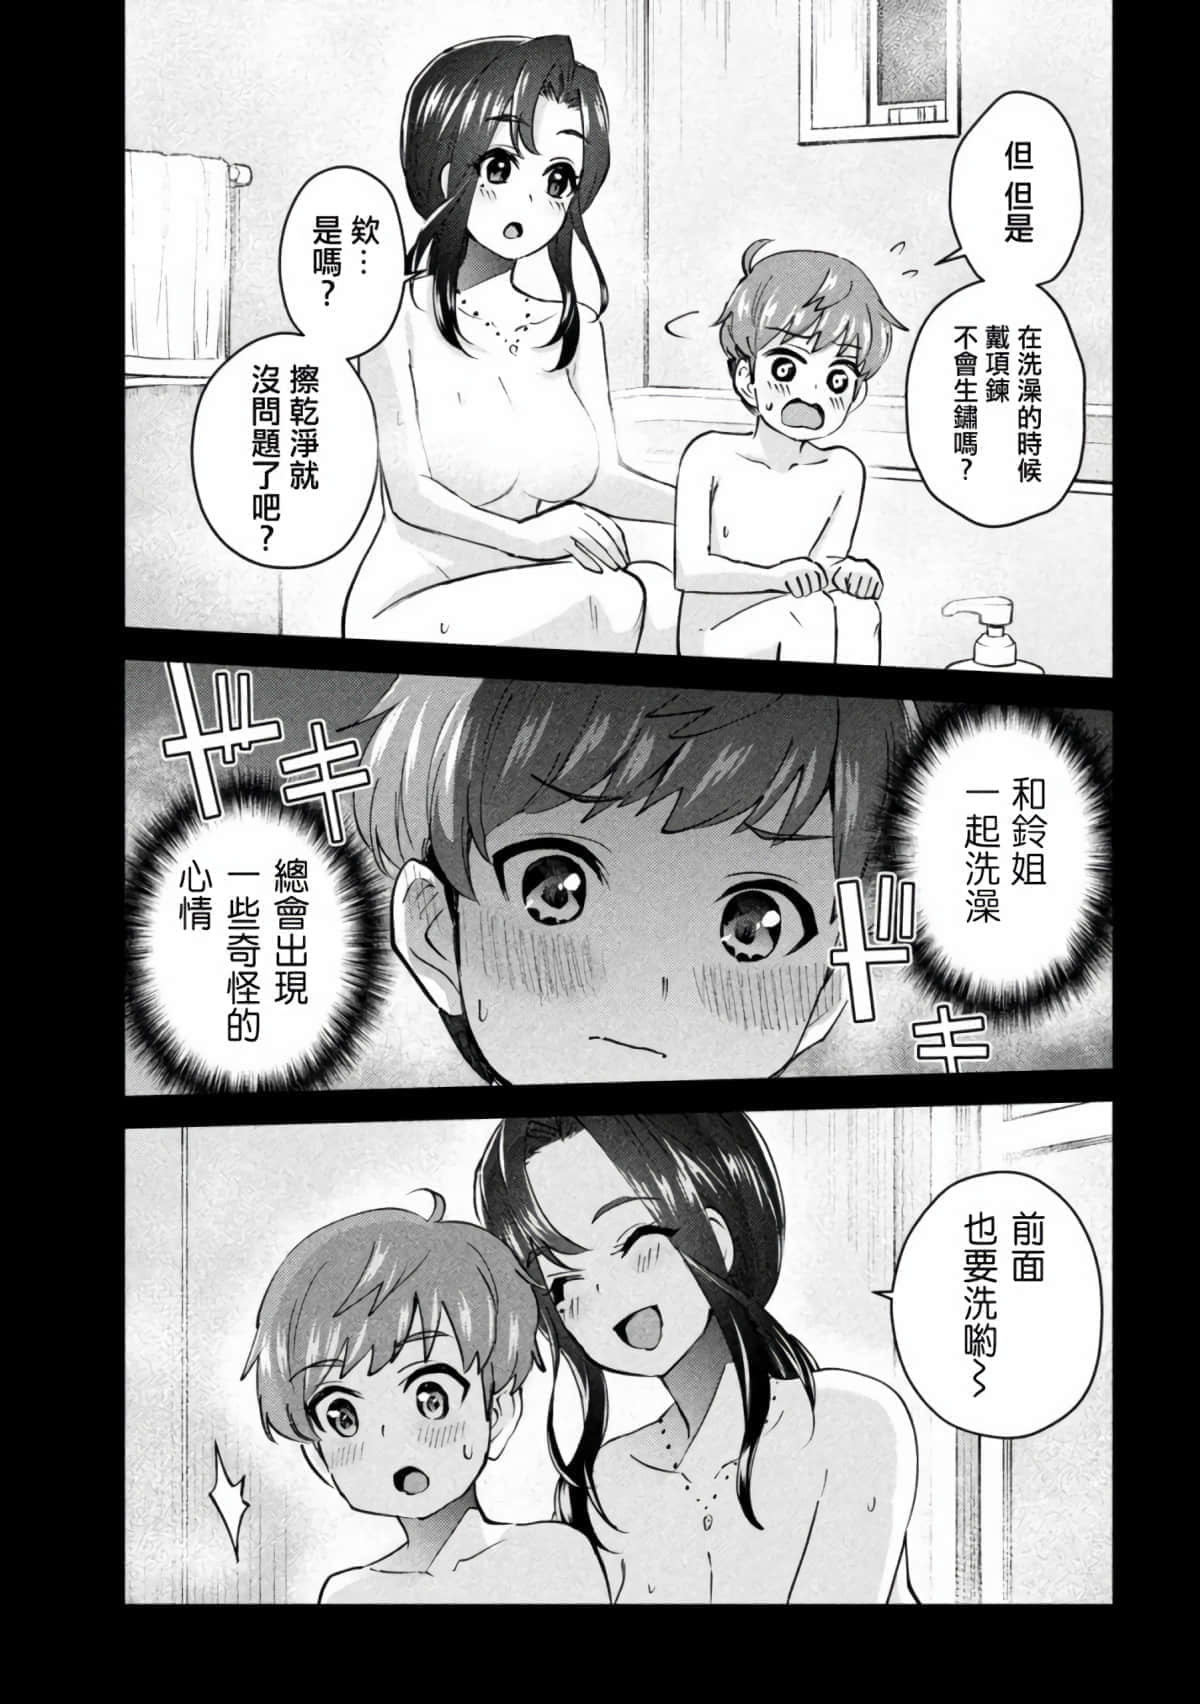

[2023/06/06 17:48:00] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/ch/ch_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='/root/.loc

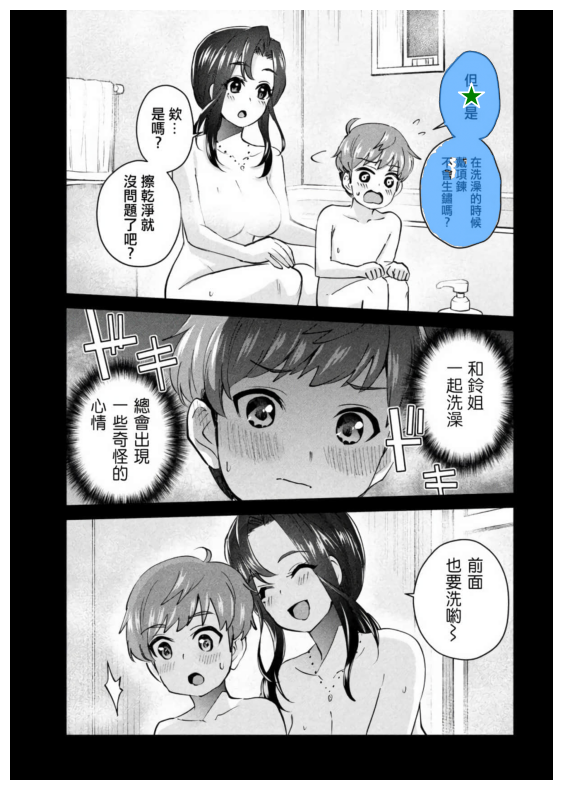

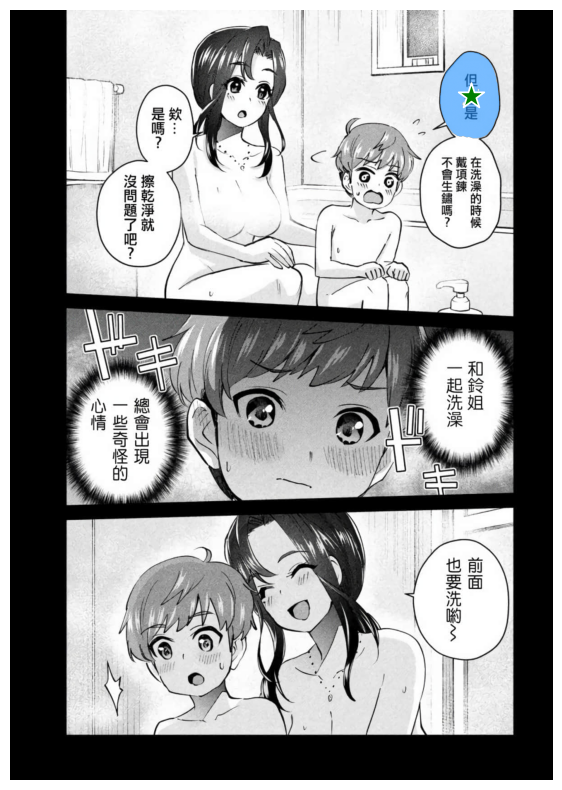

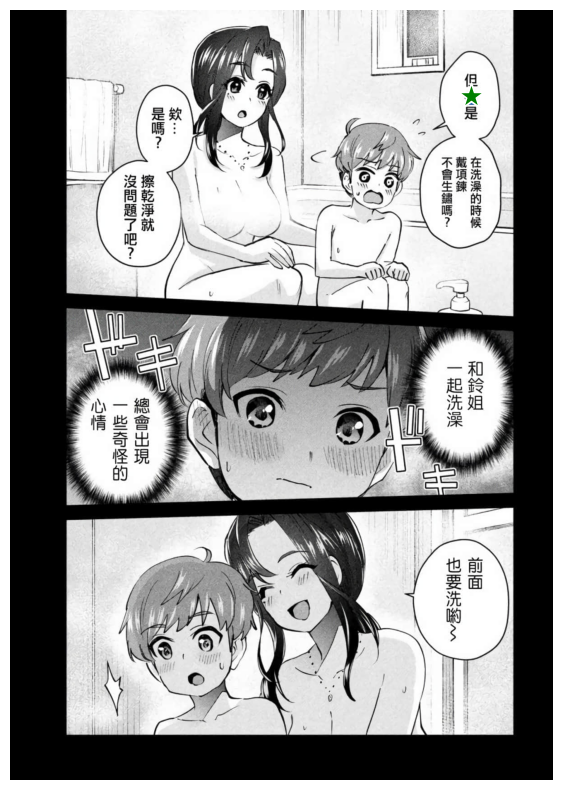

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np
from transformers import SamProcessor, SamModel
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch.optim import Adam
import monai
import cv2
from PIL import Image
from paddleocr import PaddleOCR
from utils import read_img, get_center_points_from_boxes, show_image

def run():
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    model = SamModel.from_pretrained("facebook/sam-vit-base")
    # make sure we only compute gradients for mask decoder
    for name, param in model.named_parameters():
        if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
            param.requires_grad_(False)


    image = read_img('./images/04.jpg')

    # ocr to get bounding box
    #   then get center point prompts
    ocr = PaddleOCR()
    result = ocr.ocr(image)

    score_threshold = 0.7
    boxes = [line_info[0] for line_info in result for line_info in line_info if line_info[1][1] > score_threshold]

    point_prompts = get_center_points_from_boxes(boxes)


    # input_points: list[batch_size, n-prompts, 2]
    #   processor 输出的 input_points 会在后续进行 mask 预测
    #   processor 会进行图片尺寸的调整，所以不能直接用 point_prompts
    inputs = processor(images=image, input_points=[[point_prompts[0]]], return_tensors="pt")
    for k,v in inputs.items():
        print(k,v.shape)
    
    model.to('cuda')
    img_emb = model.get_image_embeddings(inputs['pixel_values'].to('cuda'))

    outs = model(input_points=inputs['input_points'].to('cuda'),
                image_embeddings=img_emb,
                multimask_output=True
                )
    masks = processor.post_process_masks(
            outs.pred_masks, inputs["original_sizes"], inputs["reshaped_input_sizes"]
        )

    # show mask image
    from copy import deepcopy
    for mask in masks[0][0]:
        o_img = deepcopy(image)
        # 这里图片是原始图片，故而 points 使用原始的 point_prompts
        show_image(o_img, points=np.array([point_prompts[0]]), mask=mask.cpu())

run()